In [1]:
!git clone https://github.com/uonat/SS2023_DI-Lab_Precitaste.git

Cloning into 'SS2023_DI-Lab_Precitaste'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 261 (delta 88), reused 212 (delta 53), pack-reused 0
Receiving objects: 100% (261/261), 23.53 MiB | 30.08 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [2]:
%cd '/kaggle/working/SS2023_DI-Lab_Precitaste'

/kaggle/working/SS2023_DI-Lab_Precitaste


In [3]:
!git fetch

In [4]:
!git branch -v -a

* main                               2df23e7 Bug fix
  remotes/origin/CLIP-implementation 134fe54 Updated CLIP Notebook
  remotes/origin/HEAD                -> origin/main
  remotes/origin/dinov2              4859060 Added second return parameter for eliminate_boxes post process
  remotes/origin/main                2df23e7 Bug fix
  remotes/origin/yushan              94fc5af Update: different TEXT_PROMPT for RPC datasets


In [5]:
!git switch dinov2

Branch 'dinov2' set up to track remote branch 'dinov2' from 'origin'.
Switched to a new branch 'dinov2'


In [6]:
!pip install . &> /dev/null

In [7]:
import distutils.core
import sys,os
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'  &> /dev/null
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])} &> /dev/null
sys.path.insert(0, os.path.abspath('./detectron2'))

In [8]:
!wget 'https://dl.fbaipublicfiles.com/detectron2/ViTDet/LVIS/mask_rcnn_vitdet_h/332434656/model_final_866730.pkl'

--2023-06-10 14:35:05--  https://dl.fbaipublicfiles.com/detectron2/ViTDet/LVIS/mask_rcnn_vitdet_h/332434656/model_final_866730.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.160.108, 99.84.160.61, 99.84.160.80, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.160.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2669063758 (2.5G) [binary/octet-stream]
Saving to: ‘model_final_866730.pkl’

model_final_866730. 100%[===================>]   2.49G   208MB/s    in 11s     

2023-06-10 14:35:17 (222 MB/s) - ‘model_final_866730.pkl’ saved [2669063758/2669063758]



In [9]:
import numpy as np
import cv2
import torch, detectron2
from detectron2.utils.visualizer import Visualizer
from detectron2.config import LazyConfig,instantiate
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.logger import setup_logger
setup_logger()


def load_model(model_path,config_path): #mask_rcnn_vitdet_h_100ep.py
    cfg = LazyConfig.load(config_path)
    model =  instantiate(cfg.model)
    DetectionCheckpointer(model).load(model_path)
    return model

In [10]:
def crop_object_with_bbox(np_img, bbox):
    x, y, x2, y2 = [int(i) for i in bbox]
    return np_img[y:y2, x:x2].astype('float32')

In [11]:
import json
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torchvision.transforms as T
from PIL import Image
from sklearn.model_selection import train_test_split

In [12]:
# Dataset paths
rpc_main_path = '/kaggle/input/retail-product-checkout-dataset'
knn_train_features_path = '/kaggle/input/idp-repo/rpc-train-dinov2-feat/rpc-train-dinov2-feat'
val_size = 0.2
random_seed = 12

In [13]:
from dataset.RPCDataset import RPCDataset
val_dataset = RPCDataset(rpc_main_path, 'val')

In [14]:
sub_classes = val_dataset.get_class_names()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
train_sub_classes, val_sub_classes = train_test_split(sub_classes, test_size=val_size, random_state=random_seed)
#train_seen_classes, train_unseen_classes = train_test_split(train_sub_classes, test_size=unseen_class_ratio, random_state=random_seed)

In [16]:
model_path ="/kaggle/working/SS2023_DI-Lab_Precitaste/model_final_866730.pkl"
config_path = "/kaggle/working/SS2023_DI-Lab_Precitaste/detectron2/projects/ViTDet/configs/LVIS/mask_rcnn_vitdet_h_100ep.py"
object_proposer_model = load_model(model_path,config_path)
object_proposer_model.to(device)
object_proposer_model.eval()
print()

[06/10 14:35:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/SS2023_DI-Lab_Precitaste/model_final_866730.pkl ...



In [17]:
def calculate_iou(bbox1, bbox2):
    """
    Calculates the Intersection over Union (IoU) between two bounding boxes.
    Bounding boxes are represented as (x_min, y_min, x_max, y_max).
    Returns:
        IoU value between 0 and 1.
    """
    # Calculate the intersection area
    x_min_inter = max(bbox1[0], bbox2[0])
    y_min_inter = max(bbox1[1], bbox2[1])
    x_max_inter = min(bbox1[2], bbox2[2])
    y_max_inter = min(bbox1[3], bbox2[3])
    
    intersection_area = max(0, x_max_inter - x_min_inter + 1) * max(0, y_max_inter - y_min_inter + 1)
    
    # Calculate the union area
    bbox1_area = (bbox1[2] - bbox1[0] + 1) * (bbox1[3] - bbox1[1] + 1)
    bbox2_area = (bbox2[2] - bbox2[0] + 1) * (bbox2[3] - bbox2[1] + 1)
    
    union_area = bbox1_area + bbox2_area - intersection_area
    
    # Calculate the IoU
    iou = intersection_area / union_area
    
    return iou

def find_gt_bboxes_of_pred(pred_bboxes, pred_scores, gt_bboxes, iou_thres=0.5):
    """
    For a given prediction boundig boxes and their confidence, returns the index of the 
    gt bounding boxes that matches with the predictions.
    First sorts all prediction bounding boxes and measures the iou with all gt boxes. 
    Two boxes will be considered as matched when their iou is above iou_threshold. 
    Then marks that matched gt as used and for all remaining predictions does the same 
    with remaining unused gt boxes. 
    Returns:
        Two lists, first one is for matched gt bbox index and -1 for unmatched gt bboxes
        secon list is for unfound gt bbox indices.
    """
    # Sort prediction bounding boxes by their scores in descending order
    sorted_indices = sorted(range(len(pred_scores)), key=lambda k: pred_scores[k], reverse=True)
    
    # Initialize an array to store the matched gt bbox indices (-1 for unmatched gt bboxes)
    matched_gt_indices = [-1] * len(pred_bboxes)
    
    # Iterate over the sorted prediction bounding boxes
    for pred_index in sorted_indices:
        pred_bbox = pred_bboxes[pred_index]
        
        # Initialize variables to track the maximum IoU and the corresponding gt bbox index
        max_iou = 0
        max_iou_index = -1
        
        # Iterate over the gt bounding boxes
        for gt_index, gt_bbox in enumerate(gt_bboxes):
            # Calculate the IoU between the prediction bbox and the gt bbox
            iou = calculate_iou(pred_bbox, gt_bbox)
            
            # If the IoU is above the threshold and higher than the previous maximum IoU,
            # update the maximum IoU and the corresponding gt bbox index
            # Also the gt bounding box didn't matched with another prediction before
            if iou > iou_thres and iou > max_iou and gt_index not in matched_gt_indices:
                max_iou = iou
                max_iou_index = gt_index
        
        # If a matching gt bbox is found, mark it as used and store the index in the results array
        if max_iou_index != -1:
            matched_gt_indices[pred_index] = max_iou_index
    
    unmatched_gt_indices = [i for i in range(len(gt_bboxes)) if i not in matched_gt_indices]
    # Return the matched gt bbox indices array
    return matched_gt_indices, unmatched_gt_indices

In [18]:
class Prediction:
    def __init__(self, img_name, img_path, pred_bbox, pred_score_bbox):
        self.img_name = img_name
        self.img_path = img_path
        
        if pred_bbox is not None:
            self.pred_bbox = pred_bbox.tolist()
        else:
            self.pred_bbox = None
            
        self.pred_score_bbox = pred_score_bbox

        # Obtained when prediction matches with a gt bounding box
        self.gt_bbox = None
        self.gt_label = None

        # Obtained from knn
        self.pred_label = None
        # Obtained from knn by measuring mean distance to its predicted label
        self.class_score = None
        self.pred_features = None
        self.is_train = None
        
    def add_gt_bbox(self, gt_bbox, gt_label, train_class_flag):
        self.gt_bbox = gt_bbox
        self.gt_label = gt_label
        self.is_train = train_class_flag
        
    def add_classification_res(self, pred_feats, pred_label, mean_dist):
        self.pred_features = pred_feats
        self.pred_label = pred_label
        self.class_score = mean_dist
        
    def to_dict(self):
        return {
            'img_name': self.img_name,
            'img_path': self.img_path,
            'pred_bbox': self.pred_bbox,
            'pred_score_bbox': self.pred_score_bbox,
            'gt_bbox': self.gt_bbox,
            'gt_label': self.gt_label,
            'pred_label': self.pred_label,
            'class_score': self.class_score,
            'pred_features': self.pred_features,
            'is_train': self.is_train
        }
    
    def read_dict(self, content):
        self.img_name = content['img_name']
        self.img_path = content['img_path']
        self.pred_bbox = content['pred_bbox']
        
        self.pred_score_bbox = content['pred_score_bbox']
        self.gt_bbox = content['gt_bbox']
        self.gt_label = content['gt_label']
        self.pred_label = content['pred_label']
        self.class_score = content['class_score']
        self.pred_features = content['pred_features']

In [19]:
img_idx = np.arange(0, val_dataset.get_num_imgs())
train_img_idx, val_img_idx = train_test_split(img_idx, test_size=val_size, random_state=random_seed)

In [20]:
import json

config = {
    'train_sub_classes': train_sub_classes,
    'val_sub_classes': val_sub_classes,
    'train_img_idx': train_img_idx.tolist(),
    'val_img_idx': val_img_idx.tolist()
}
with open('../train_config.json', 'w') as jfile:
    json.dump(config, jfile)

In [21]:
from utilities.non_maximum_suppression import run_nms 
from utilities.bbox_postprocess import eliminate_boxes

def get_pred_objects(img_indices):
    prediction_objects = []
    post_processed_prediction_objects = []
    with torch.no_grad():
        for i in tqdm(img_indices):
            element = val_dataset.get_element_by_id(i)
            
            pil_img = Image.open(element['img_path'])
            el_gt_annots = element['annots']
            h,w = pil_img.size
            
            img = T.PILToTensor()(pil_img.convert("RGB"))
            resized_img = T.Resize((int(h/4), int(w/4)), antialias=None)(img)    
            batch = [{'image':resized_img.to(device)}]
            model_result=object_proposer_model(batch)

            picked_boxes, picked_score = run_nms(
                model_result[0]['instances'].pred_boxes.tensor.to(torch.int).tolist(),
                model_result[0]['instances'].scores.tolist(),
                np.asarray(img),
                0.5
            )
            denormed_boxes = np.array(picked_boxes) * 4
            
            remaining_boxes, remaining_boxes_indices = eliminate_boxes(denormed_boxes, h, w, area_thres=0.6, eps=10, return_bbox_indices=True)
            remaining_scores = [picked_score[i] for i in remaining_boxes_indices] 
            
            # Extract label and bounding box of annotations and convert bboxes to xyxy format
            el_gt_bboxes = np.array([annot[0] for annot in el_gt_annots])
            el_gt_labels = np.array([annot[1] for annot in el_gt_annots])
            el_gt_bboxes[:, 2] = el_gt_bboxes[:, 0] + el_gt_bboxes[:, 2]
            el_gt_bboxes[:, 3] = el_gt_bboxes[:, 1] + el_gt_bboxes[:, 3]

            corresponding_bbox_index, unmatched_bbox_index = find_gt_bboxes_of_pred(denormed_boxes, picked_score, el_gt_bboxes)
            corresponding_post_bbox_index, unmatched_post_bbox_index = find_gt_bboxes_of_pred(remaining_boxes, remaining_scores, el_gt_bboxes)
            
            for i, box in enumerate(denormed_boxes):
                # Discard very small objects
                if (box[2] - box[0]) < 224 and (box[3] - box[1]) < 224:
                    continue

                cur_object = Prediction(element['img_name'], element['img_path'], box, picked_score[i])

                if corresponding_bbox_index[i] != -1:
                    matched_gt_annot_idx = corresponding_bbox_index[i]
                    matched_gt_annot = el_gt_annots[matched_gt_annot_idx]

                    is_train_class = matched_gt_annot[1] in train_sub_classes

                    cur_object.add_gt_bbox(matched_gt_annot[0], matched_gt_annot[1], is_train_class)

                prediction_objects.append(cur_object)
            
            for ind in unmatched_bbox_index:
                not_found_bbox = el_gt_annots[matched_gt_annot_idx]
                cur_object = Prediction(element['img_name'], element['img_path'], None, None)
                
                is_train_class = not_found_bbox[1] in train_sub_classes
                cur_object.add_gt_bbox(not_found_bbox[0], not_found_bbox[1], is_train_class)
                
                prediction_objects.append(cur_object)
                
            for i, box in enumerate(remaining_boxes):
                # Discard very small objects
                if (box[2] - box[0]) < 224 and (box[3] - box[1]) < 224:
                    continue

                cur_object = Prediction(element['img_name'], element['img_path'], box, remaining_scores[i])

                if corresponding_post_bbox_index[i] != -1:
                    matched_gt_annot_idx = corresponding_post_bbox_index[i]
                    matched_gt_annot = el_gt_annots[matched_gt_annot_idx]

                    is_train_class = matched_gt_annot[1] in train_sub_classes

                    cur_object.add_gt_bbox(matched_gt_annot[0], matched_gt_annot[1], is_train_class)

                post_processed_prediction_objects.append(cur_object)
            
            for ind in unmatched_post_bbox_index:
                not_found_bbox = el_gt_annots[matched_gt_annot_idx]
                cur_object = Prediction(element['img_name'], element['img_path'], None, None)
                
                is_train_class = not_found_bbox[1] in train_sub_classes
                cur_object.add_gt_bbox(not_found_bbox[0], not_found_bbox[1], is_train_class)
                
                post_processed_prediction_objects.append(cur_object)                
                
                
        return prediction_objects, post_processed_prediction_objects

In [22]:
def dump_pred_objects(prediction_objects, jpath):
    json_content = [pred_object.to_dict() for pred_object in prediction_objects]
    with open(jpath, "w") as jfile:
        json.dump(json_content, jfile)

In [23]:
pred_objects, processed_pred_objects = get_pred_objects([1, 3, 5, 8, 10])

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [24]:
def get_pred_objects_per_image(pred_objects):
    img_names = list(set([pobject.img_name for pobject in pred_objects]))
    objects_per_img = {}
    for img_name in img_names:
        img_objects = [pobject for pobject in pred_objects if pobject.img_name == img_name]
        objects_per_img[img_name] = img_objects
    return objects_per_img

In [25]:
def draw_bbox(image, bounding_boxes, color, bbox_format='xyxy'):  #IoU threshold
    org = image.copy()

    # Draw parameters
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2

    # Draw bounding boxes and confidence score
    for (start_x, start_y, end_x, end_y) in [[int(i) for i in boxes] for boxes in bounding_boxes]:
        if bbox_format == 'xyxy':
            cv2.rectangle(org, (start_x, start_y), (end_x, end_y), color, 2)
        else:
            cv2.rectangle(org, (start_x, start_y), (start_x + end_x, start_y + end_y), color, 2)            

    return org

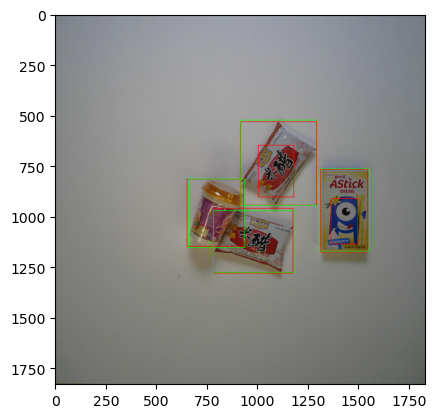

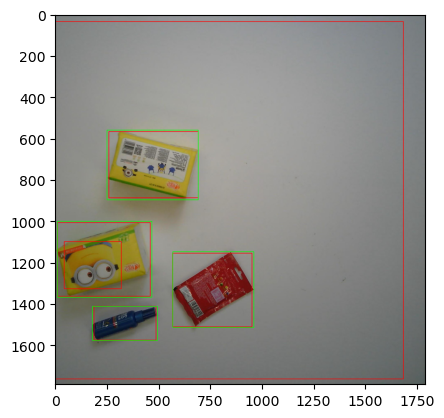

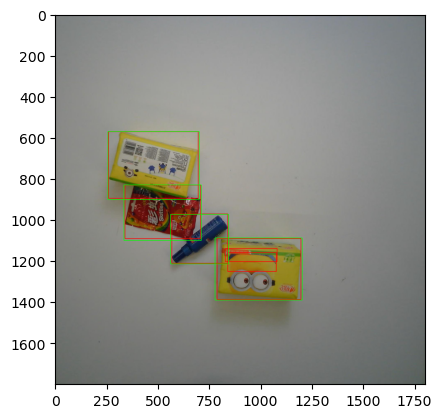

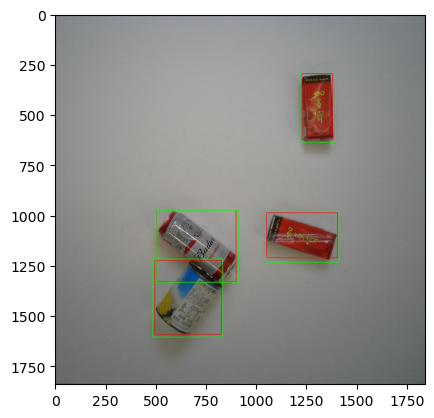

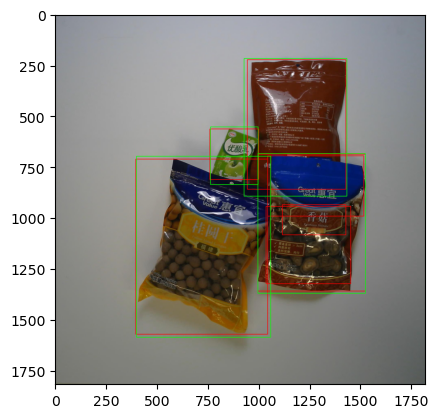

In [26]:
per_image_pred_objects = get_pred_objects_per_image(pred_objects)
for img_name in per_image_pred_objects:
    pred_objects_of_img = per_image_pred_objects[img_name]
    image_path = pred_objects_of_img[0].img_path
    pil_img = Image.open(image_path)
    pred_bboxes = [pred_object.pred_bbox for pred_object in pred_objects_of_img if pred_object.pred_bbox is not None]
    gt_bboxes = [pred_object.gt_bbox for pred_object in pred_objects_of_img if pred_object.gt_bbox is not None]
    bbox_drawn_img = draw_bbox(np.array(pil_img), pred_bboxes, (255, 0,0))
    bbox_drawn_img = draw_bbox(bbox_drawn_img, gt_bboxes, (0, 255,0), bbox_format='xywh')
    
    plt.figure()
    plt.imshow(bbox_drawn_img)
    plt.show()

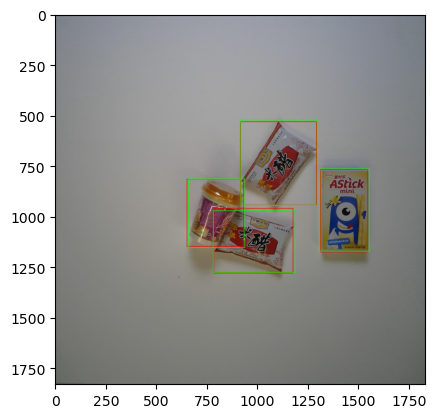

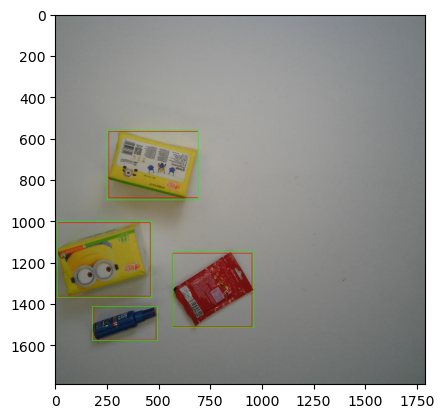

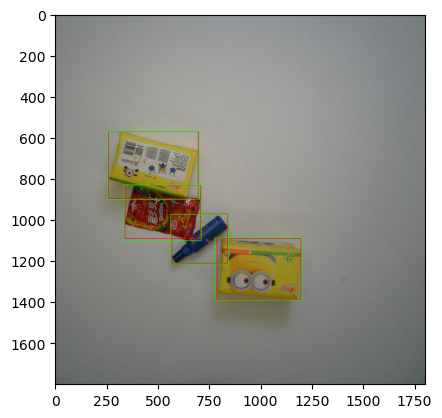

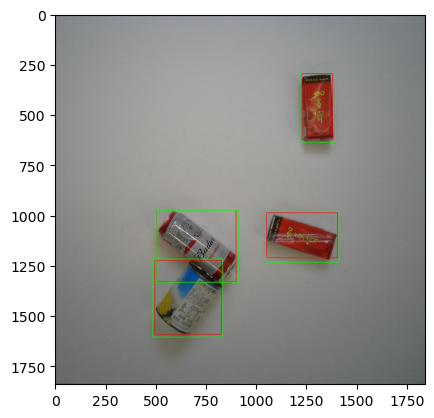

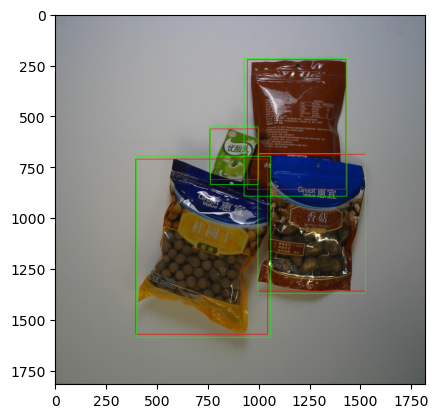

In [27]:
per_image_pred_objects = get_pred_objects_per_image(processed_pred_objects)
for img_name in per_image_pred_objects:
    pred_objects_of_img = per_image_pred_objects[img_name]
    image_path = pred_objects_of_img[0].img_path
    pil_img = Image.open(image_path)
    pred_bboxes = [pred_object.pred_bbox for pred_object in pred_objects_of_img if pred_object.pred_bbox is not None]
    gt_bboxes = [pred_object.gt_bbox for pred_object in pred_objects_of_img if pred_object.gt_bbox is not None]
    bbox_drawn_img = draw_bbox(np.array(pil_img), pred_bboxes, (255, 0,0))
    bbox_drawn_img = draw_bbox(bbox_drawn_img, gt_bboxes, (0, 255,0), bbox_format='xywh')
    
    plt.figure()
    plt.imshow(bbox_drawn_img)
    plt.show()

In [28]:
pred_objects, processed_pred_objects = get_pred_objects(train_img_idx)
dump_pred_objects(pred_objects, "../vith_res_train_pred_objects.json")
dump_pred_objects(processed_pred_objects, "../vith_res_train_processed_pred_objects.json")

  0%|          | 0/4800 [00:00<?, ?it/s]

In [29]:
pred_objects, processed_pred_objects = get_pred_objects(val_img_idx)
dump_pred_objects(pred_objects, "../vith_res_val_pred_objects.json")
dump_pred_objects(processed_pred_objects, "../vith_res_val_processed_pred_objects.json")

  0%|          | 0/1200 [00:00<?, ?it/s]

In [30]:
def read_pred_objects_json(json_path):
    pred_objects = []
    with open(json_path, "r") as jfile:
        json_objects = json.load(jfile)    
    
    for json_object in json_objects:
        cur_object = Prediction("", "", [], 0.0)
        cur_object.read_dict(json_object)
        pred_objects.append(cur_object)
    return pred_objects